In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
rating_df = pd.read_csv("Book reviews/BX-Book-Ratings.csv", sep=';', error_bad_lines=False, encoding="latin-1")
rating_df.columns = ["user_id","isbn","rating"]
books_df = pd.read_csv("Book reviews/BX_Books.csv", sep=';', error_bad_lines=False, encoding="latin-1")
books_df = books_df[["ISBN","Book-Title","Book-Author"]]
books_df.columns = ["isbn","book_title","book_author"]

In [3]:
print(rating_df.isnull().sum())
print(books_df.isnull().sum())

user_id    0
isbn       0
rating     0
dtype: int64
isbn           0
book_title     0
book_author    1
dtype: int64


In [4]:
books_df[books_df["book_author"].isnull() == True]

,isbn,book_title,book_author
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN


In [5]:
books_df = books_df.fillna("Unknown")

In [6]:
def encode_data(df, col_name, id2name=False):
    """ Encodes rating data with continous user and ids. 
    """
    df = df.copy()
    uniq = df[col_name].unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    if id2name:
        id2name = {i:o for i,o in enumerate(uniq)}
        return id2name, np.array([name2idx.get(x, -1) for x in df[col_name]])
    return name2idx, np.array([name2idx.get(x, -1) for x in df[col_name]])
    

In [34]:
# taking only a sample of the whole dataset only to skip high processing time

reduced_rating_df = shuffle(rating_df).iloc[:5000]
encoded_df = pd.DataFrame(reduced_rating_df["rating"])
user2id_encoded, encoded_df["user_id"] = encode_data(reduced_rating_df, col_name="user_id")
id2book_encoded, encoded_df["isbn"] = encode_data(reduced_rating_df, col_name="isbn", id2name=True)


In [35]:
# min and max ratings will be used to normalize the ratings
min_rating = min(encoded_df["rating"])
max_rating = max(encoded_df["rating"])

encoded_df["rating"] = encoded_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [36]:
encoded_df

,rating,user_id,isbn
162882,0.0,0,0
744957,0.0,1,1
1089973,0.0,2,2
251432,0.8,3,3
817432,0.0,4,4
...,...,...,...
573285,1.0,3166,4642
738825,0.8,3167,4643
471961,0.0,3168,4644
625140,0.8,2472,4645


In [37]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df[['user_id', 'isbn']].values, encoded_df["rating"].values,
                                                   test_size=0.2)

In [38]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_books, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.book_embedding = layers.Embedding(
            num_books,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.book_bias = layers.Embedding(num_books, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        # Add all the components (including bias)
        x = dot_user_book + user_bias + book_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [75]:
EMBEDDING_SIZE = 50
num_users = len(user2id_encoded)
num_books = len(id2book_encoded)
    
model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))

In [76]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=100,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test),
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


4000/4000 [==============================] - 2s 596us/sample - loss: 0.6928 - val_loss: 0.6929
Epoch 2/10
4000/4000 [==============================] - 1s 182us/sample - loss: 0.6082 - val_loss: 0.6918
Epoch 3/10
4000/4000 [==============================] - 1s 181us/sample - loss: 0.6035 - val_loss: 0.6909
Epoch 4/10
4000/4000 [==============================] - 1s 185us/sample - loss: 0.5996 - val_loss: 0.6900
Epoch 5/10
4000/4000 [==============================] - 1s 186us/sample - loss: 0.5950 - val_loss: 0.6891
Epoch 6/10
4000/4000 [==============================] - 1s 185us/sample - loss: 0.5907 - val_loss: 0.6881
Epoch 7/10
4000/4000 [==============================] - 1s 185us/sample - loss: 0.5875 - val_loss: 0.6871
Epoch 8/10
4000/4000 [==============================] - 1s 183us/sample - loss: 0.5844 - val_loss: 0.6861
Epoch 9/10
4000/4000 [==============================] - 1s 186us/sample - loss: 0.5846 - val_loss: 0.6853
Epoch 10/10
4000/4000 [==============================] - 

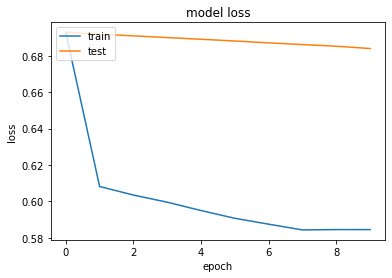

In [77]:
## Plot training and validation loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [78]:
# Top recommendations for a random user

user_id = encoded_df.user_id.sample(3).iloc[0]
books_read_by_user = encoded_df[encoded_df.user_id == user_id]
books_not_read = encoded_df[encoded_df.user_id != user_id]["isbn"].values.reshape(-1,1)



user_encoder = user_id

user_book_array = np.hstack(([[user_encoder]] * len(books_not_read), books_not_read))\

ratings = model.predict(user_book_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_book_ids = [id2book_encoded.get(books_not_read[x][0]) for x in top_ratings_indices]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Books with high ratings from user")
print("----" * 8)
top_books_user = ( books_read_by_user.sort_values(by="rating", ascending=False).head(5).isbn.values)
decoded_rated_books = [id2book_encoded.get(x) for x in top_books_user]
book_df_rows = books_df[books_df["isbn"].isin(decoded_rated_books)]
for row in book_df_rows.itertuples():
    print(row.book_title)

print("----" * 8)
print("Top 10 Books recommendations")
print("----" * 8)
recommended_books = books_df[books_df["isbn"].isin(recommended_book_ids)]
for row in recommended_books.itertuples():
    print(row.book_title)

Showing recommendations for user: 1341
Books with high ratings from user
--------------------------------
The Cave
The Invisible Partners: How the Male and Female in Each of Us Affects Our Relationships
Critical Questions
Common Ground: A Turbulent Decade in the Lives of Three American Families
--------------------------------
Top 10 Books recommendations
--------------------------------
Die SÃ?Â¤ulen der Erde. Roman.
Neverwhere
The Power of Myth (Illustrated Edition)
Into the Wild
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Midwives: A Novel
The Hobbit
I Know Why the Caged Bird Sings
The Beach House
